# Object Detection on Final Four Basketball Game Using Yolov5

In in this project I use the Yolov5 object detection architecture which is pre-trained on the [COCO Dataset](https://cocodataset.org/) to detect the different team players.

The Basketball game is a Final Four game between Duke and North Carolina. The Final Four is the nickname of the final round of both the men's and women's NCAA Division I basketball tournaments, which are single-elimination tournaments to determine the U.S. national champion.

## Project outline

I detect four classes:
* `Player_light_blue_jersey` (Duke)
* `Player_white_jersey` (North Carolina)
* `referee`
* `other` (representing those who are not players or referres).

The aim of the project is to effectively detect each player during a short video of the game. To do this I train the pre-trained `YOLOv5s` (which is the smallest pre-trained Yolov5 model) on 58 images taken (at different time stamps) from the video (see ....py file). 

I will add data Augmentation using roboflow. For each image in the training set I apply three augmentations (Saturation, Brightness and Exposure randomly from the range -25% to +25%). This increases my image dataset to a total of 135 images ((training, validation, testing) = (117, 10, 8)).

I then train the Yolov5s on the 117 1280x1280 coulored images in batches of 16 over 100 epochs.

Once the model is trained I run inference on the video and save to my google drive.



### Clone yolov5 directory + requirements

In [6]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.2-157-g30fa9b6 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 37.6/78.2 GB disk)


In [7]:
#check we are on GPUs

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


### Get my annotated frames from roboflow

here is the link https://app.roboflow.com/final-four-project/basketball_frames/4 

In [8]:
#install roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="###############") #hidden
project = rf.workspace("final-four-project").project("basketball_frames")
dataset = project.version(4).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 4.0 MB/s 
     |████████████████████████████████| 178 kB 27.3 MB/s 
     |████████████████████████████████| 1.1 MB 49.0 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 138 kB 62.0 MB/s 
     |████████████████████████████████| 62 kB 776 kB/s 
  Created wheel for roboflow: filename=roboflow-0.2.15-py3-none-any.whl size=24936 sha256=981dc44e86d7526dea370ab1e5207916500f244ffe40e39f1dbb60bf1efa564a
  Stored in directory: /root/.cache/pip/wheels/13/e0/a3/fe183fffc3972cb9264e800763d4bbfff80d5309137c410217
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=dacfd200c561d46482f1bba345e8f0da3a4e6279c5200e710959baa030fe6034
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Basketball_Frames-4 in yolov5pytorch:: 100%|██████████| 282/282 [00:00<00:00, 1005.94it/s]


In [9]:
#dataset is stored as roboflow Dataset object
type(dataset)
print(dataset.location)

/content/yolov5/Basketball_Frames-4


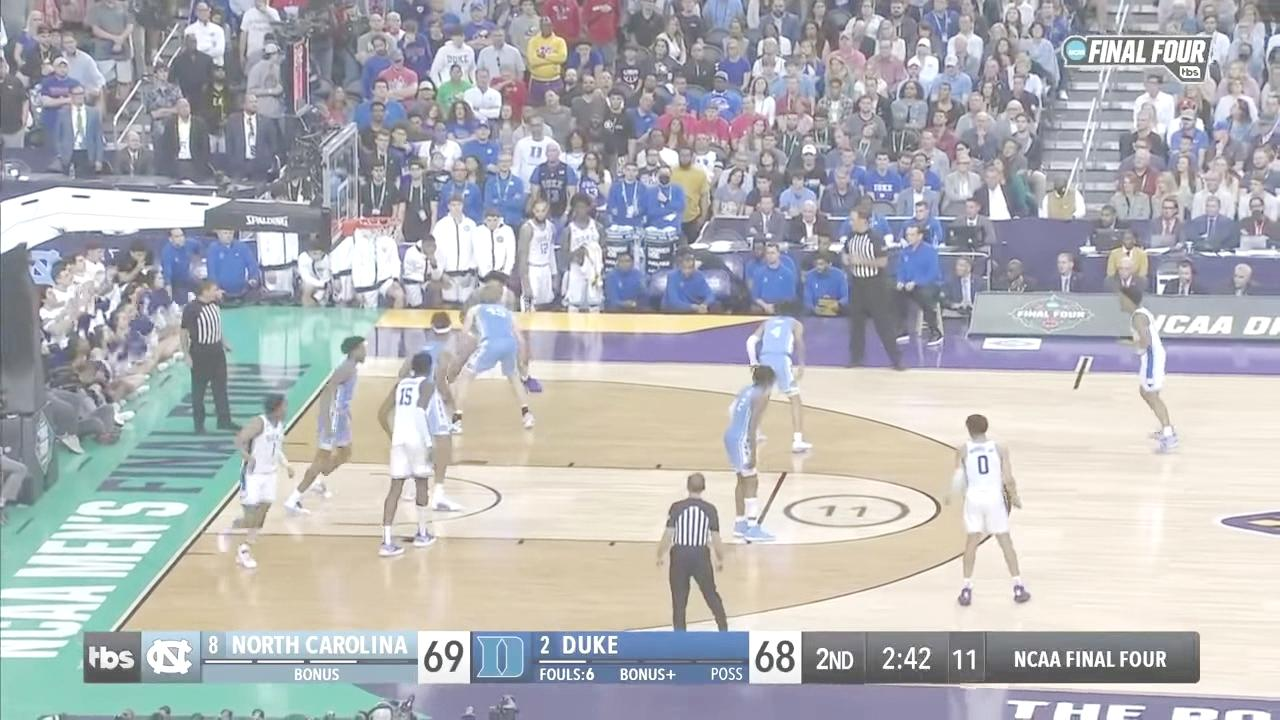

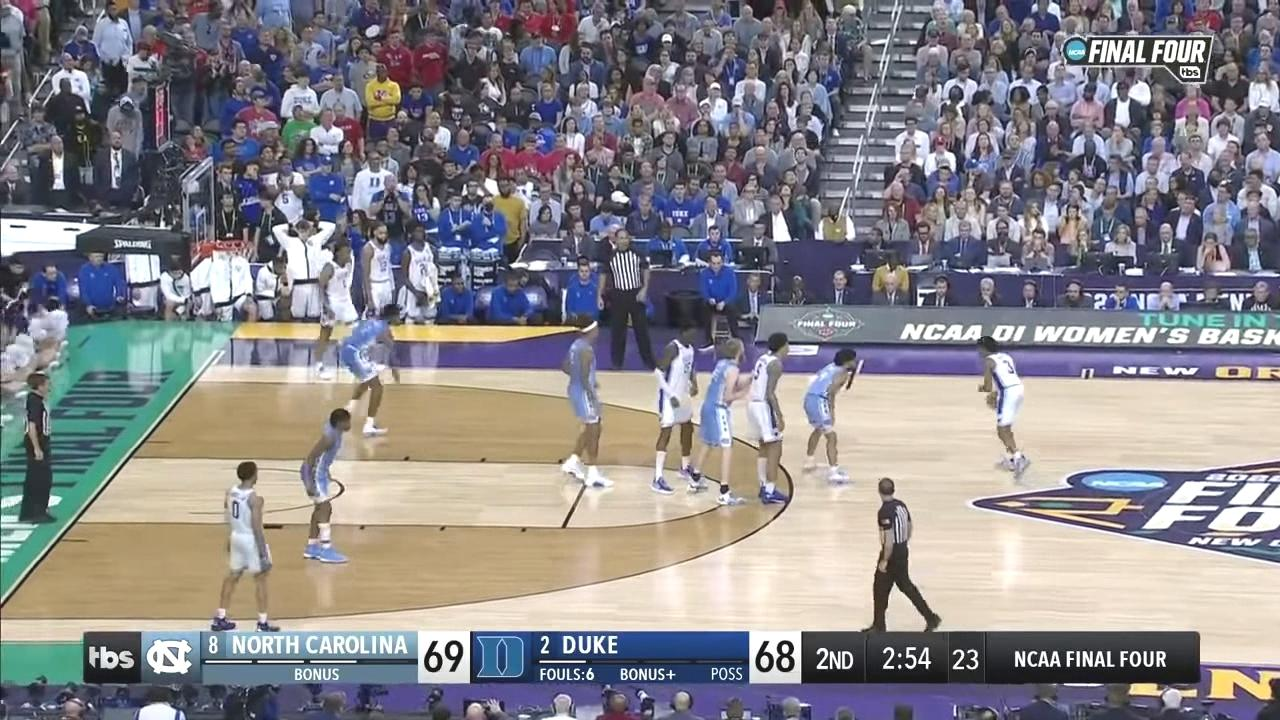

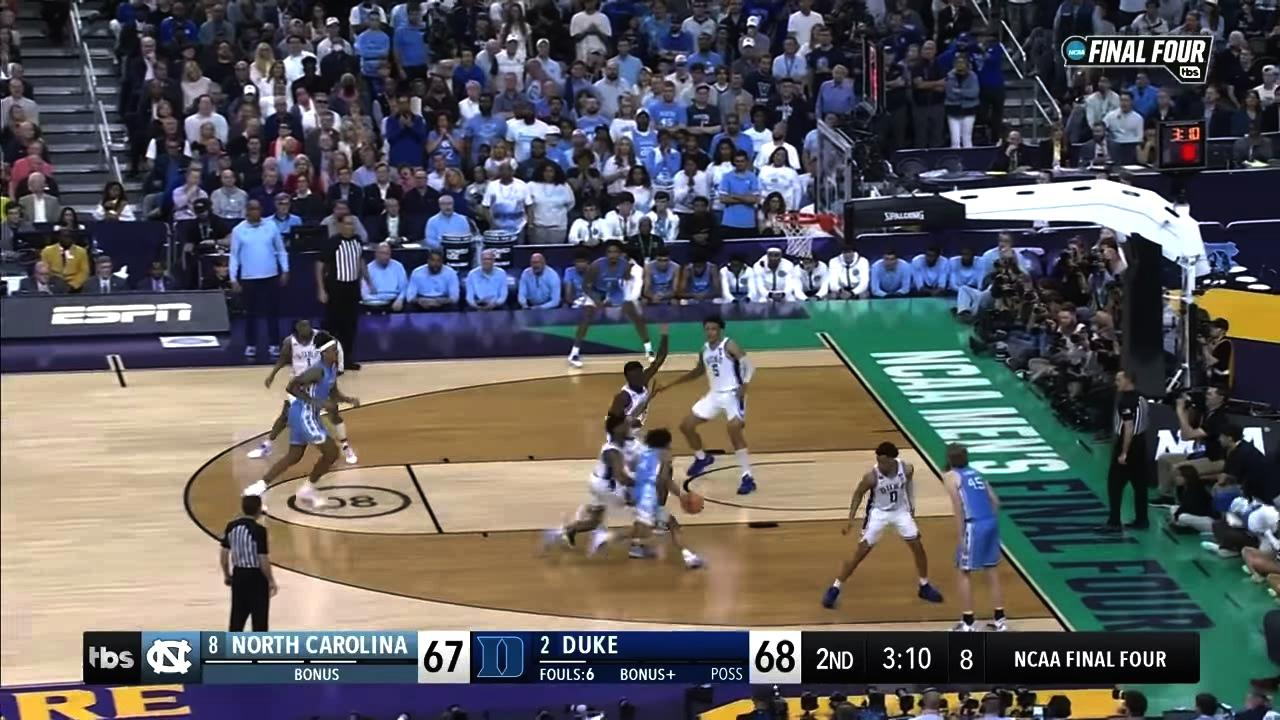

In [10]:
## see examples of the augmented images 
from glob import glob
from IPython.display import Image, display

count = 0
for imageName in glob('/content/yolov5/Basketball_Frames-4/train/images/*.jpg'):
    if count == 3:
      break
    
    display(Image(filename=imageName))
    print("\n")
    count +=1
  
  

### Yolov5 Quick Explaination

As YOLO v5 is a single-stage object detector, it has three important parts like any other single-stage object detector.

#### 1) Model Backbone

The model Backbone is used to extract important features from the input image. In YOLO v5 the CSP — Cross Stage Partial Networks are used as a backbone to extract features from an image

#### 2) Model Neck

The model Neck is used to generate feature pyramids. Feature pyramids help models to generalized well on object scaling. They help in identifing the same object with different sizes and scales.

Yolov5 uses PANet as its neck to get feature pyramids

#### 3) Model Head

The model Head is used to perform the final detection part. It applies anchor boxes on features and generates final output vectors with class probabilities, objectness scores, and bounding boxes.

In YOLO v5 model head is the same as the previous YOLO V3 and V4 versions.

### Train (pre-trained) Yolov5s Model 

Since I did not resize my images (in pre processing) img size is 1280x1280

Loading pre-trained weights as yolov5s.pt (note: the pt) - if I was training model from scratch I'd leave the `weights` parameter empty and use `config` parameter instead


In [11]:
#To train model - run the train.py file
!python train.py --img 1280 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache --project 'basketball_runs' --name 'run_1' 

train: weights=yolov5s.pt, cfg=, data=/content/yolov5/Basketball_Frames-4/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=basketball_runs, name=run_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-157-g30fa9b6 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamm

### Training Results

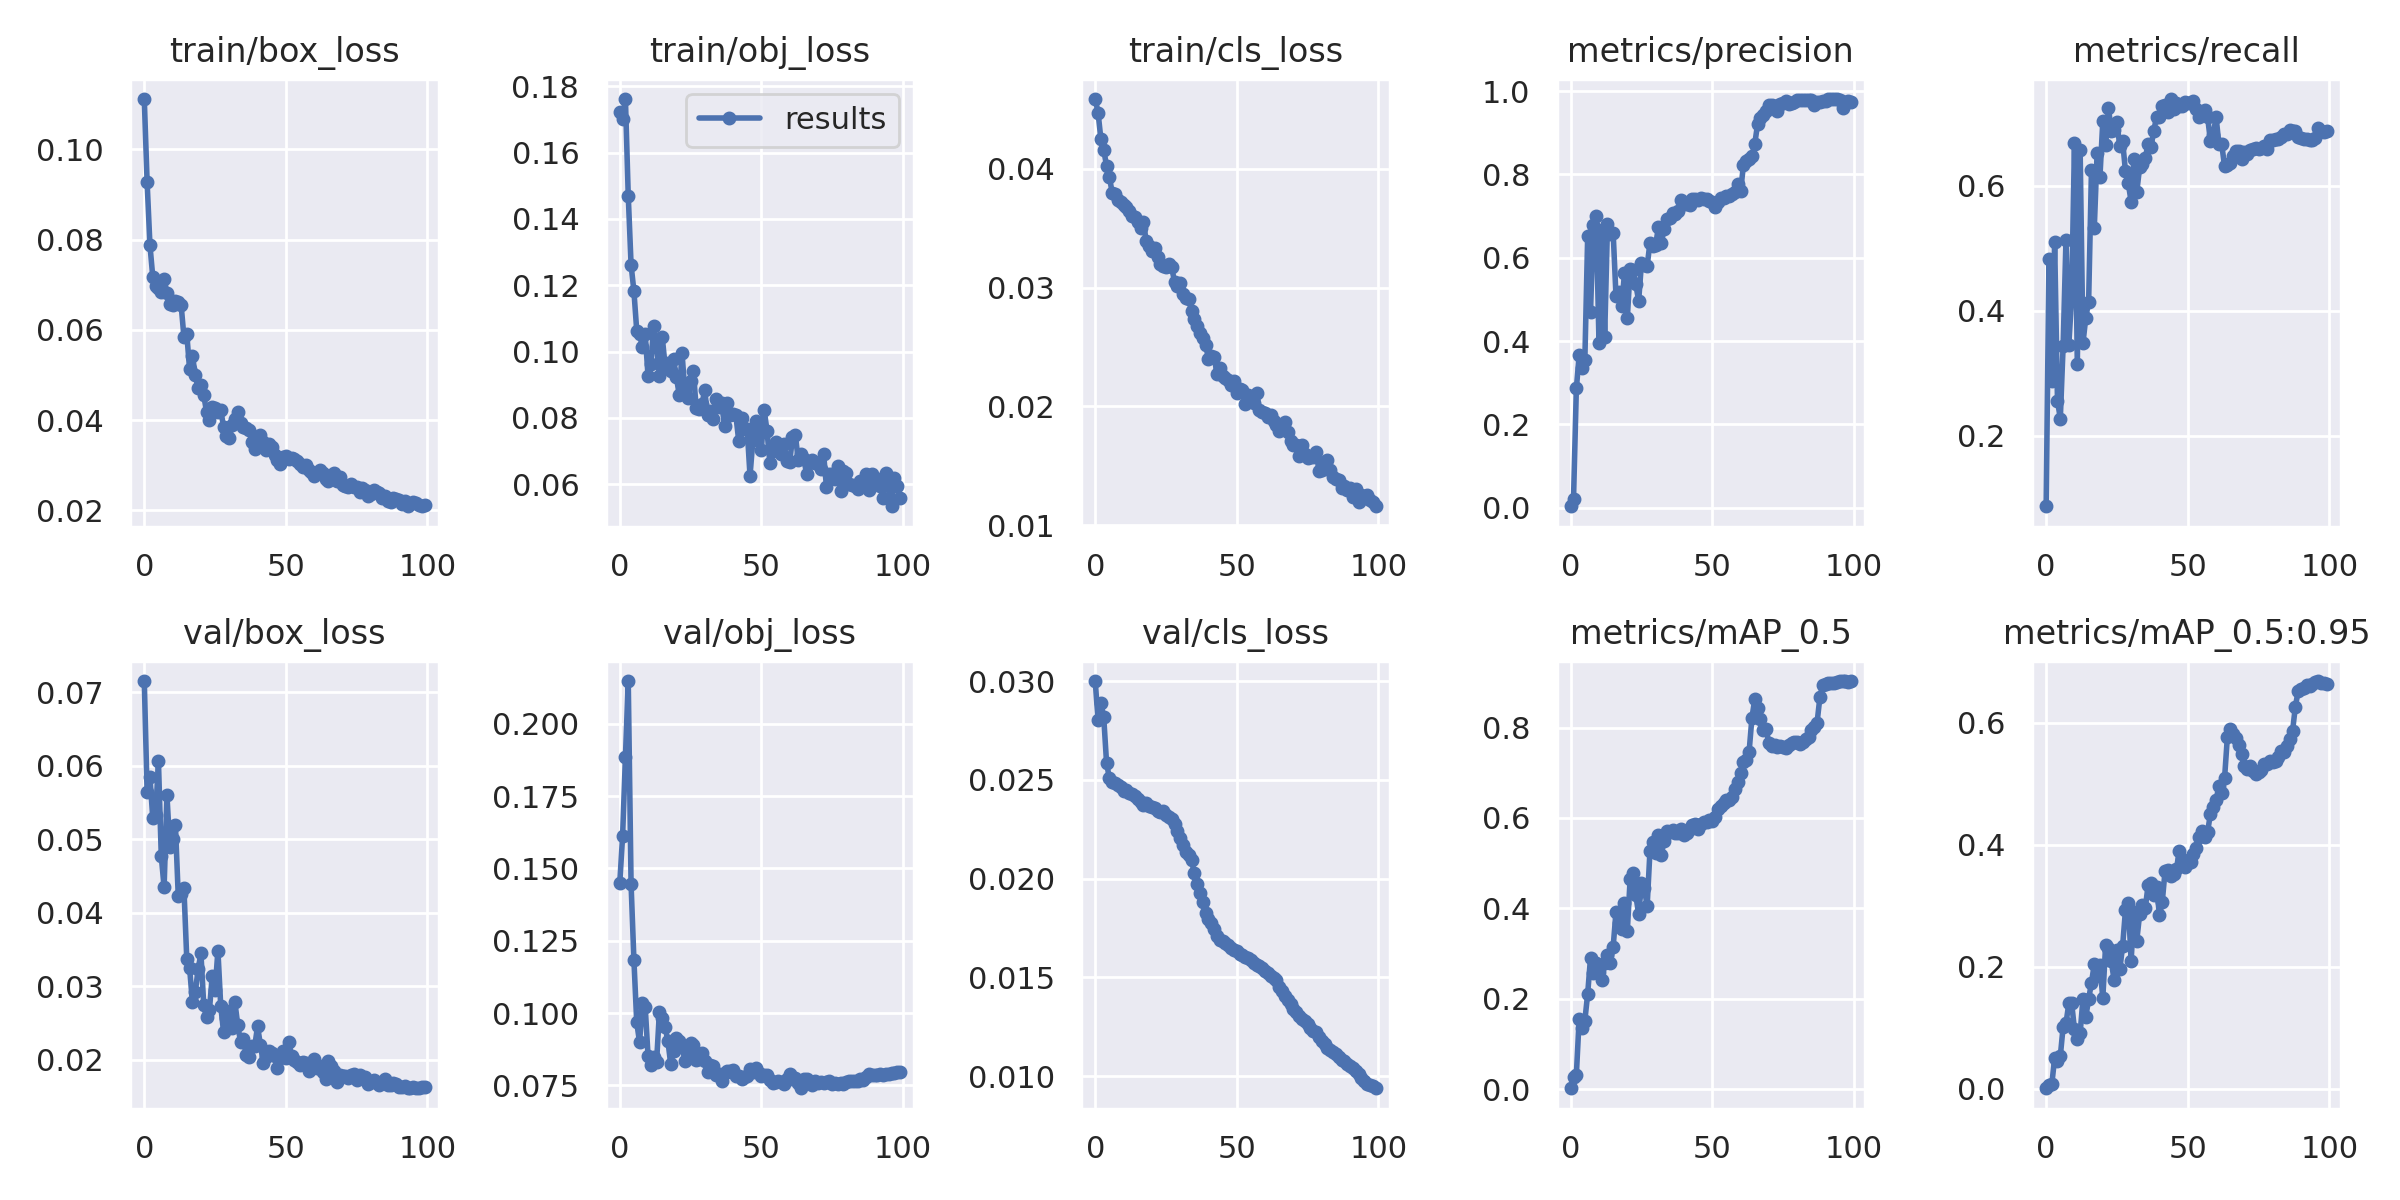

In [12]:
from PIL import Image 
img = Image.open("./basketball_runs/run_1/results.png")
img

### Run Inference With Trained Weights on Test image dataset

Now that the model is trained we can run inference on the test images. 
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

--img is 1280
-- conf (is the confidence threshold display a box if confidence is over this value!!) defult 0.25 

In [14]:
!python detect.py --weights basketball_runs/run_1/weights/best.pt --img 1280 --conf 0.25 --source {dataset.location}/test/images

detect: weights=['basketball_runs/run_1/weights/best.pt'], source=/content/yolov5/Basketball_Frames-4/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-157-g30fa9b6 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/yolov5/Basketball_Frames-4/test/images/frame0-00-01-00_jpg.rf.54062fd38c30b5cca6991663bc7fab05.jpg: 736x1280 7 player_light_blue_jerseys, 5 player_white_jerseys, 3 referees, 22.5ms
image 2/8 /content/yolov5/Basketball_Frames-4/test/images/frame0-00-20-02_jpg.rf.2fc1ee47041a01ee92f80e3493db

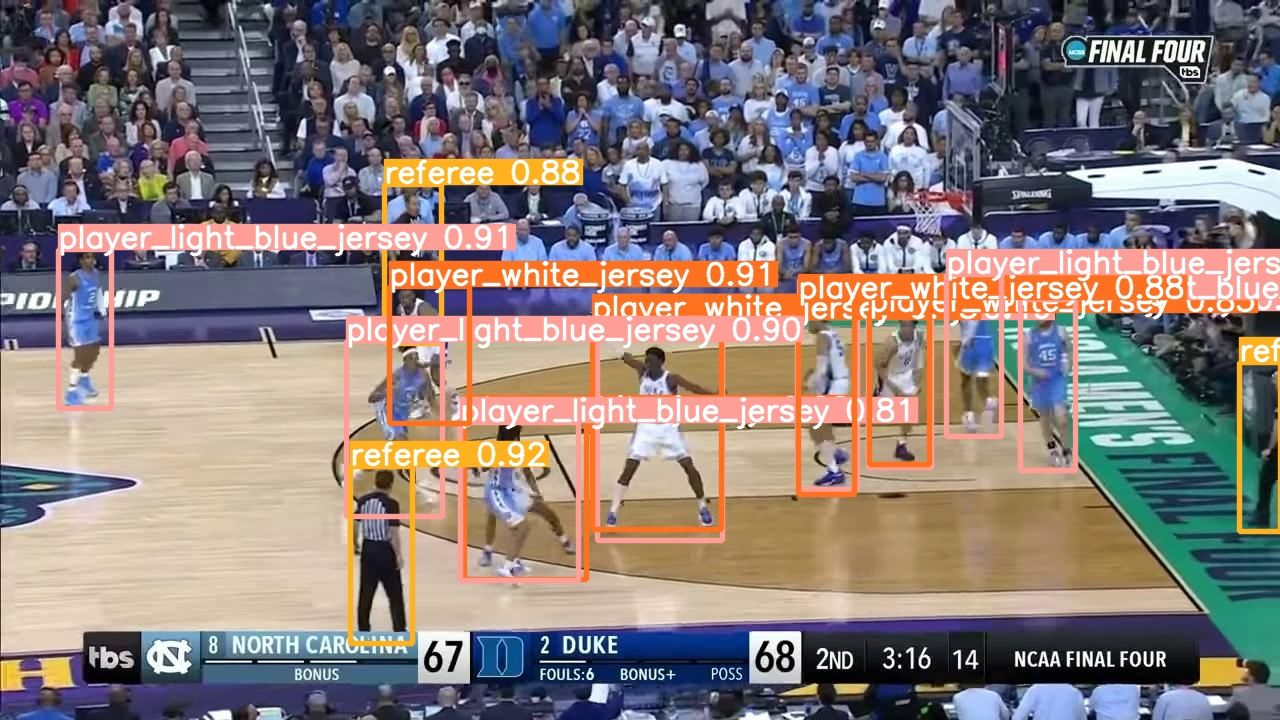

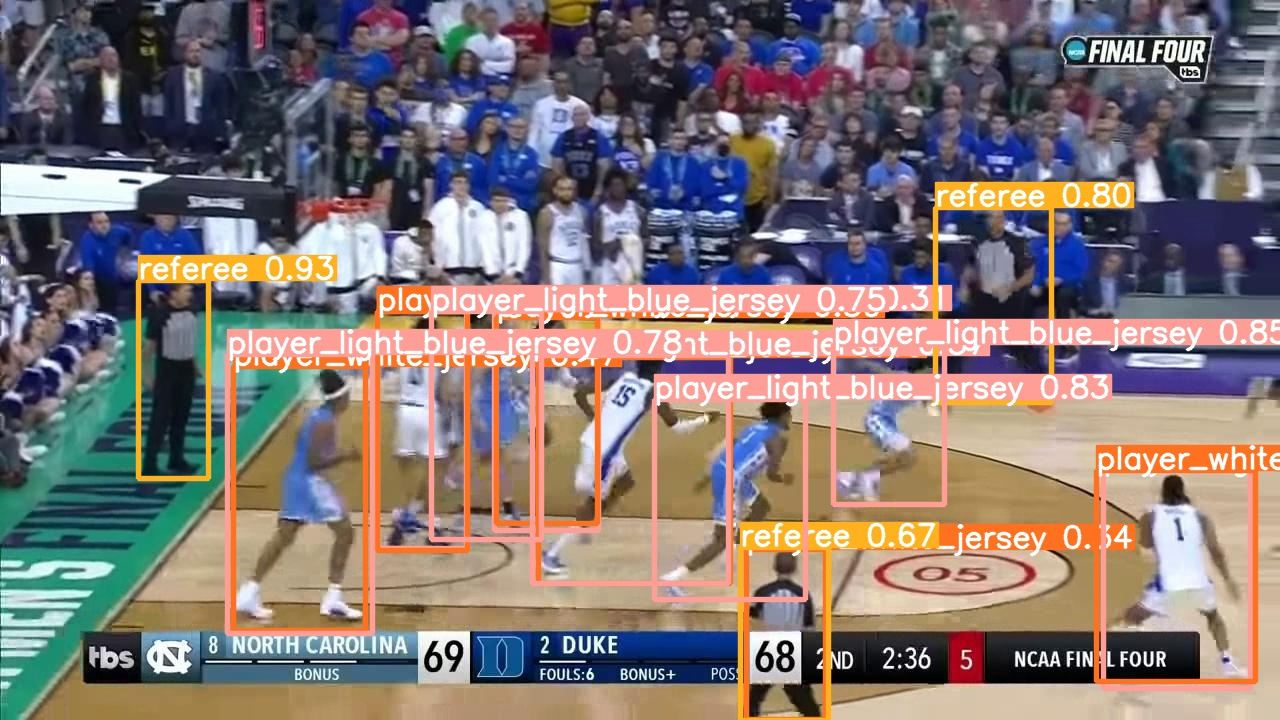

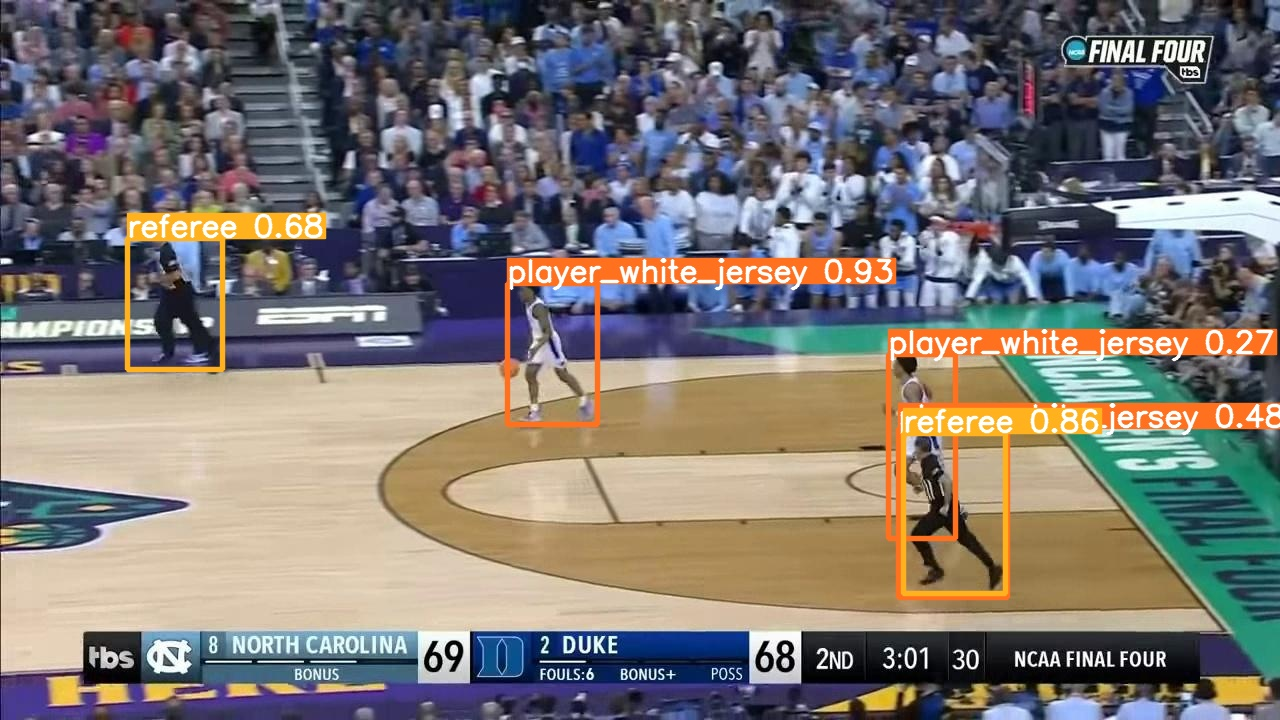

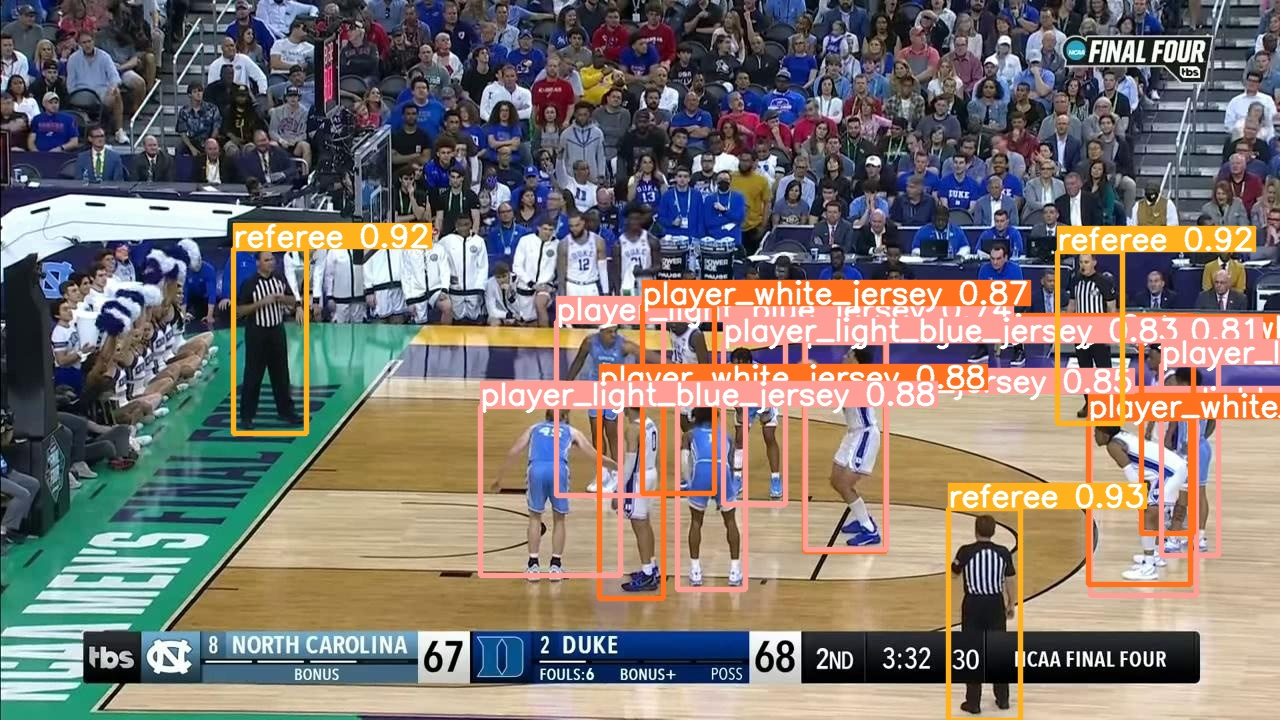

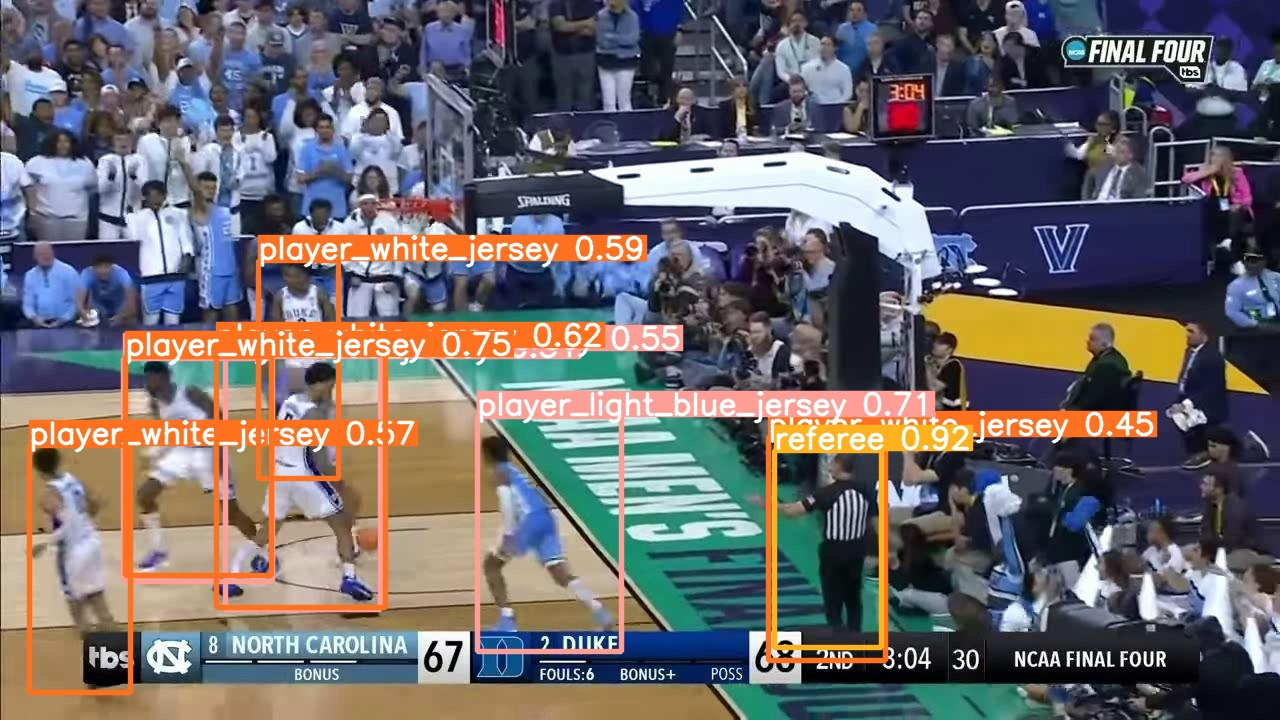

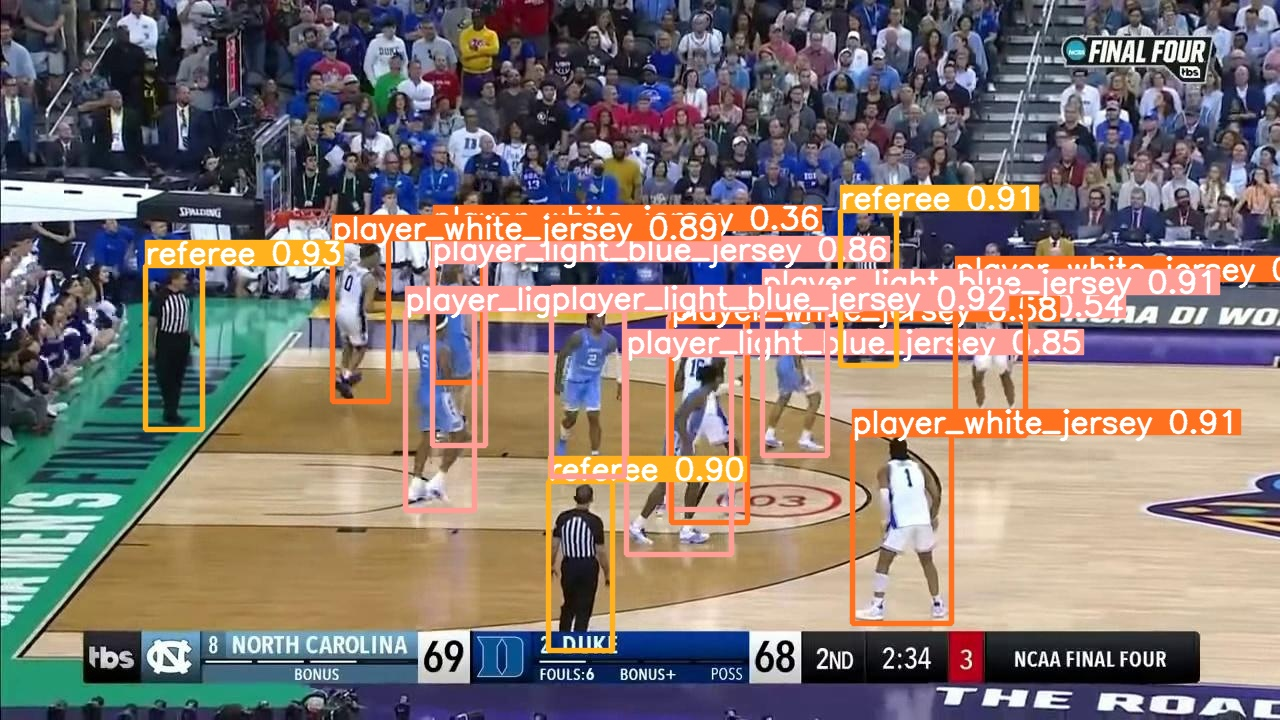

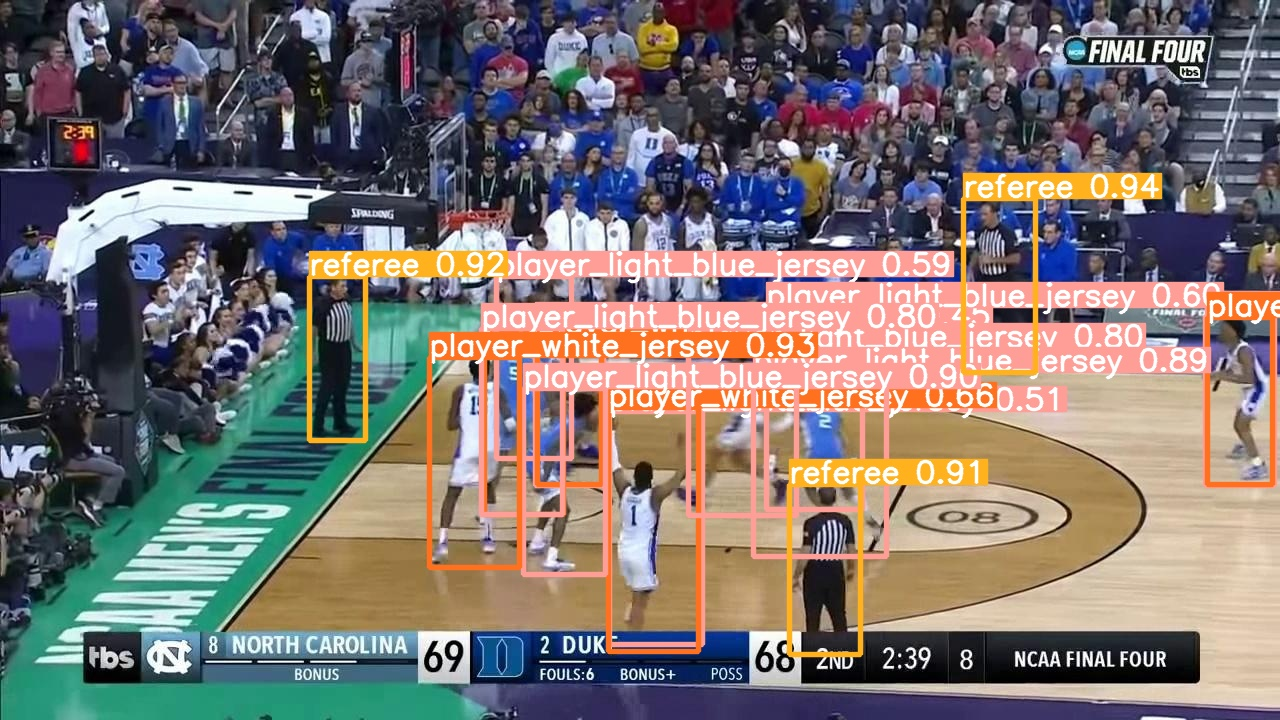

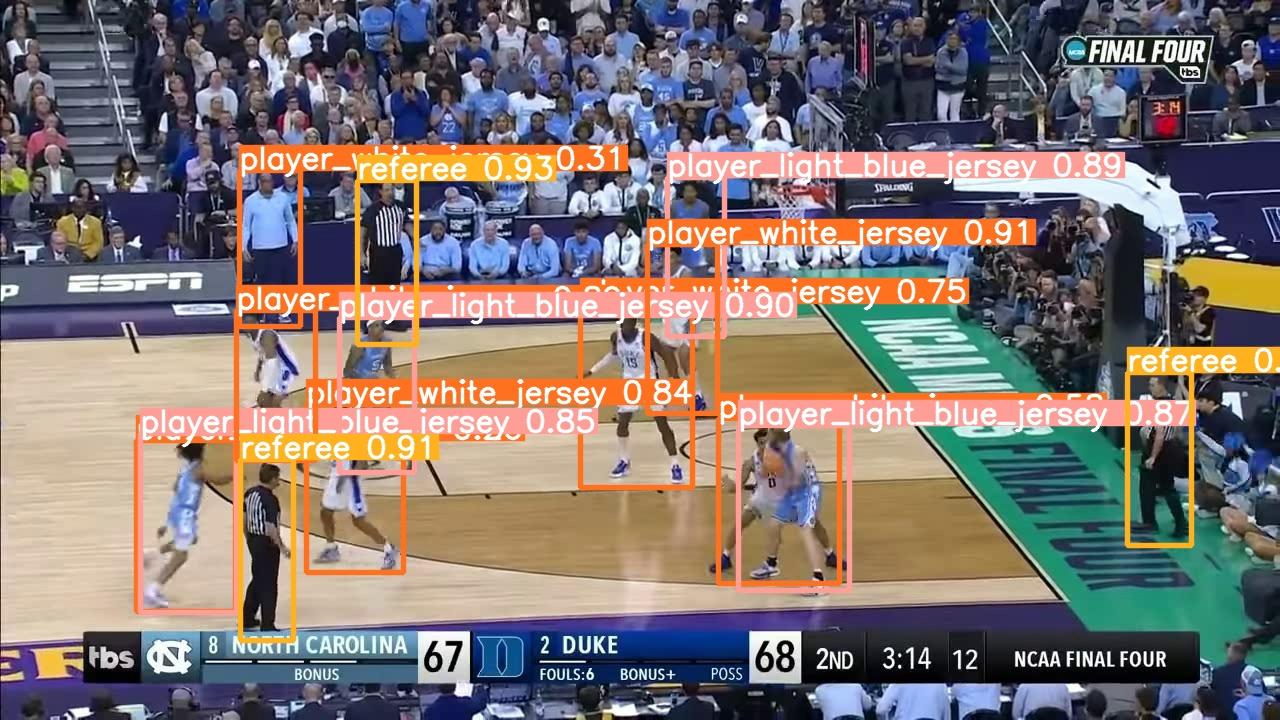

In [16]:
## print the inference on the test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

## Run Inference With Trained Weights on Final Four Video 

I uploaded the video manually to the yolov5 directory on colab - (Note: will have to do it for each runtime).

use `save` parameter to save the results

In [ ]:
!python detect.py --weights basketball_runs/run_1/weights/best.pt --img 1280 --conf 0.25 --source /content/drive/MyDrive/CLEAN_final_four.mp4 --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/CLEAN_final_four.mp4, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-94-g1aea74c Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/1888) /content/drive/MyDrive/CLEAN_final_four.mp4: 736x1280 5 player_light_blue_jerseys, 5 player_white_jerseys, 3 referees, 22.2ms
video 1/1 (2/1888) /content/drive/MyDrive/CLEAN_final_four.mp4: 736x1280 5 player_light_blue_jerseys, 5 player_white_jerseys, 3 referees, 22.1ms
video 1/1 (3/1888) /content/driv

View the final video inference here: https://stream.new/v/V3A5sbQ9bFCUry01qh00Mi8d187HgMgBce4ZdMafsObOE 

In [ ]:
## export the inferenced video

## easier to download it by copying it to drive and downloading from there
## RENAMED DETECT ON COLAB

# mount it
from google.colab import drive
drive.mount('/content/drive')

# copy it there
!cp /content/yolov5/runs/detect/exp2/DETECT_2_final_four.mp4 /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#from IPython.display import Video

#Video("DETECT_2_final_four.mp4")